In [65]:
import os
import re
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2


In [ ]:
BASE_DIR = '/caption-dataset'
WORKING_DIR = '/output'
IMAGES_DIR = os.path.join(BASE_DIR, 'Images')

In [67]:
## Extract Image Features

In [68]:
# load vgg16 model
model = VGG16()
# restructure the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# summarize
print(model.summary())

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [69]:
# Dictionary to hold features for each image
features = {}

# Define valid image extensions (all in lower-case for consistent checking)
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.gif')

# Loop over all files in the images directory
for img_name in tqdm(os.listdir(IMAGES_DIR)):
    # Check if the file has a valid image extension (case-insensitive)
    if not img_name.lower().endswith(valid_extensions):
        print(f"Skipping file (invalid extension): {img_name}")
        continue

    # Construct full image path
    img_path = os.path.join(IMAGES_DIR, img_name)

    # Attempt to load the image
    try:
        image = load_img(img_path, target_size=(224, 224))
    except Exception as e:
        print(f"Error loading image {img_name}: {e}")
        continue

    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Add a batch dimension (1, height, width, channels)
    image = np.expand_dims(image, axis=0)
    # Preprocess image for VGG16
    image = preprocess_input(image)

    # Extract features using the model
    feature = model.predict(image, verbose=0)

    # Get the image ID (filename without extension)
    image_id = os.path.splitext(img_name)[0]
    # Store the extracted feature in the dictionary
    features[image_id] = feature

  0%|          | 0/151 [00:00<?, ?it/s]

Skipping file (invalid extension): .DS_Store


In [70]:
# store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [71]:
# load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

In [72]:
## Load Captions Data

In [73]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [74]:
# create mapping of image to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # convert caption list to string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/851 [00:00<?, ?it/s]

In [75]:
len(mapping)

142

In [76]:
## Preprocess Text Data

In [77]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # delete digits, special chars, etc.,
            caption = caption.replace('[^A-Za-z]', '')
            # delete additional spaces
            caption = caption.replace('\s+', ' ')
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [78]:
# before preprocess of text
mapping['IMG_4507']

['A K-pop idol with long black hair  wearing a blue button-up shirt  playfully pointing to her cheek.',
 'A K-pop idol with long black hair  wearing a blue button-up shirt  gently resting her finger on her cheek.',
 'A K-pop idol in a blue button-up shirt  making a cute cheek gesture while smiling.',
 'A K-pop idol with dark hair  dressed in a blue shirt  playfully pressing her finger to her cheek.',
 'A K-pop idol with long black hair  in a blue shirt  pointing at her cheek with a bright expression.']

In [79]:
# preprocess the text
clean(mapping)

In [80]:
# after preprocess of text
mapping['IMG_4507']

['startseq k-pop idol with long black hair wearing blue button-up shirt playfully pointing to her cheek. endseq',
 'startseq k-pop idol with long black hair wearing blue button-up shirt gently resting her finger on her cheek. endseq',
 'startseq k-pop idol in blue button-up shirt making cute cheek gesture while smiling. endseq',
 'startseq k-pop idol with dark hair dressed in blue shirt playfully pressing her finger to her cheek. endseq',
 'startseq k-pop idol with long black hair in blue shirt pointing at her cheek with bright expression. endseq']

In [81]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [82]:
len(all_captions)

710

In [83]:
all_captions[:10]

['startseq k-pop idol with long black hair wearing blue button-up shirt playfully pointing to her cheek. endseq',
 'startseq k-pop idol with long black hair wearing blue button-up shirt gently resting her finger on her cheek. endseq',
 'startseq k-pop idol in blue button-up shirt making cute cheek gesture while smiling. endseq',
 'startseq k-pop idol with dark hair dressed in blue shirt playfully pressing her finger to her cheek. endseq',
 'startseq k-pop idol with long black hair in blue shirt pointing at her cheek with bright expression. endseq',
 'startseq k-pop idol with long black hair dressed in brown fur-lined top softly gazing into the camera. endseq',
 'startseq k-pop idol with sleek black hair wearing brown fur-lined top giving gentle expression. endseq',
 'startseq k-pop idol in cozy fur-trimmed outfit looking warmly at the camera. endseq',
 'startseq k-pop idol with long dark hair dressed in fur-lined top offering soft stare. endseq',
 'startseq k-pop idol in brown fur outf

In [84]:

# Define a function to clean captions
def clean_caption(caption):
    caption = caption.lower()  # Convert to lowercase
    caption = re.sub(r'[^a-z0-9\s]', '', caption)  # Remove punctuation
    return caption

# Clean all captions
all_captions_cleaned = [clean_caption(cap) for cap in all_captions]

# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [85]:
vocab_size

694

In [86]:
# Ensure the directory exists
os.makedirs(WORKING_DIR, exist_ok=True)

# Save the tokenizer to WORKING_DIR
tokenizer_path = os.path.join(WORKING_DIR, 'tokenizer.pkl')
with open(tokenizer_path, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

# Load the tokenizer from WORKING_DIR
with open(tokenizer_path, 'rb') as tokenizer_file:
    tokenizer = pickle.load(tokenizer_file)

In [87]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

21

**Train Test Split**

In [88]:
# image_ids = list(mapping.keys())
# split = int(len(image_ids) * 0.90)
# train = image_ids[:split]
# test = image_ids[split:]

image_ids = list(mapping.keys())

train_split = int(len(image_ids) * 0.80)
val_split   = int(len(image_ids) * 0.90)

train = image_ids[:train_split]
val   = image_ids[train_split:val_split]
test  = image_ids[val_split:]

In [89]:
# startseq girl going into wooden building endseq
#        X                   y
# startseq                   girl
# startseq girl              going
# startseq girl going        into
# ...........
# startseq girl going into wooden building      endseq

In [90]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

Model Creation

In [91]:
# # encoder model
# # image feature layers
# inputs1 = Input(shape=(4096,), name="image")
# fe1 = Dropout(0.4)(inputs1)
# fe2 = Dense(256, activation='relu')(fe1)
# # sequence feature layers
# inputs2 = Input(shape=(max_length,), name="text")
# se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
# se2 = Dropout(0.4)(se1)
# se3 = LSTM(256)(se2)

# # decoder model
# decoder1 = add([fe2, se3])
# decoder2 = Dense(256, activation='relu')(decoder1)
# outputs = Dense(vocab_size, activation='softmax')(decoder2)

# model = Model(inputs=[inputs1, inputs2], outputs=outputs)
# model.compile(loss='categorical_crossentropy', optimizer='adam')

# # plot the model
# plot_model(model, show_shapes=True)

# encoder model
# image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.5)(inputs1)                               # ↑ 0.4 -> 0.5
fe2 = Dense(256, activation='relu', kernel_regularizer=l2(1e-5))(fe1)

# sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)                                   # ↑ 0.4 -> 0.5
se3 = LSTM(256, recurrent_dropout=0.2,                    # add recurrent_dropout
           kernel_regularizer=l2(1e-5))(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu', kernel_regularizer=l2(1e-5))(decoder1)
outputs  = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [92]:
# epochs = 50
# batch_size = 2  # Use a smaller batch size
# steps = max(1, len(train) // batch_size)

# for i in range(epochs):
#     # Create data generator (ensure data_generator is defined correctly)
#     generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
#     # Fit for one epoch
#     model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

epochs = 50
batch_size = 2

steps_train = max(1, len(train) // batch_size)
steps_val   = max(1, len(val)   // batch_size)

os.makedirs("checkpoints", exist_ok=True)
checkpoint_path = "checkpoints/best.h5"

callbacks = [
    EarlyStopping(monitor="val_loss", patience=5, mode="min", restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=2, min_lr=1e-6, mode="min"),
    ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", save_best_only=True, mode="min")
]

for epoch in range(epochs):
    train_gen = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    val_gen   = data_generator(val,   mapping, features, tokenizer, max_length, vocab_size, batch_size)

    history = model.fit(
        train_gen,
        epochs=1,
        steps_per_epoch=steps_train,
        validation_data=val_gen,
        validation_steps=steps_val,
        callbacks=callbacks,
        verbose=1
    )

56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - loss: 5.4102

56/56 ━━━━━━━━━━━━━━━━━━━━ 8s 114ms/step - loss: 5.4007 - val_loss: 4.1410 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 4.0383

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 4.0365 - val_loss: 3.9931 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - loss: 3.7778

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 3.7768 - val_loss: 3.9453 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - loss: 3.5593

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 122ms/step - loss: 3.5588 - val_loss: 3.9082 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 3.3508 - val_loss: 3.9506 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 3.1537

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 3.1543 - val_loss: 3.6773 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - loss: 2.9752

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 116ms/step - loss: 2.9754 - val_loss: 3.6489 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - loss: 2.7551

56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 115ms/step - loss: 2.7560 - val_loss: 3.5723 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 120ms/step - loss: 2.4920 - val_loss: 3.6136 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - loss: 2.3408

56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 118ms/step - loss: 2.3421 - val_loss: 3.5105 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 119ms/step - loss: 2.1280 - val_loss: 3.6078 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 117ms/step - loss: 1.9651 - val_loss: 3.6212 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 1.8589 - val_loss: 3.5730 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 1.7334 - val_loss: 3.5791 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 1.6281 - val_loss: 3.6212 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 126ms/step - loss: 1.5068 - val_loss: 3.7632 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 124ms/step - loss: 1.4045 - val_loss: 3.8728 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 1.2553 - val_loss: 3.9975 - learning_rate: 0.0010
56/56 ━━━━━━━━━━━━━━━━━━━━ 7s 123ms/step - loss: 1.1953 - val_loss: 3.9351 - learning_rate: 0.0010
56/56 ━━━━

In [93]:
# save the model
model.save(WORKING_DIR+'/best_model.keras')

Generate Captions for the Image


In [94]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [95]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [96]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

# calcuate BLEU score
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

  0%|          | 0/15 [00:00<?, ?it/s]

BLEU-1: 0.480000
BLEU-2: 0.243380


/Users/benlau/Desktop/Image/.venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


Visualize the Results


In [97]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq k-pop idol with long black hair wearing blue button-up shirt playfully pointing to her cheek. endseq
startseq k-pop idol with long black hair wearing blue button-up shirt gently resting her finger on her cheek. endseq
startseq k-pop idol in blue button-up shirt making cute cheek gesture while smiling. endseq
startseq k-pop idol with dark hair dressed in blue shirt playfully pressing her finger to her cheek. endseq
startseq k-pop idol with long black hair in blue shirt pointing at her cheek with bright expression. endseq
--------------------Predicted--------------------
startseq k pop idol with long black hair wearing blue button up shirt playfully resting her finger on her cheek endseq


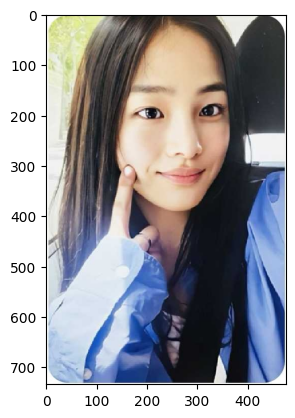

In [98]:
generate_caption("IMG_4507.JPG")